In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from utils import import_dataset, get_scores, classes
import pandas as pd
from numpy import mean, std
from tqdm.notebook import tqdm
import time
from datasets import load_dataset


In [2]:
eh_dataset = load_dataset('json', data_files='hume_json/essays_in_history.json')
eh_dataset

DatasetDict({
    train: Dataset({
        features: ['title', 'text', 'word_count', 'genre', 'labels'],
        num_rows: 67
    })
})

In [3]:
CLASSES = classes

In [ ]:
def test_model(model, x_test, y_test, title, matrix=False, print_=False):
    pred = model.predict(x_test)
    accuracy = get_scores(pred, y_test, title=title, matrix=matrix, print_=print_)
    return accuracy, pred

In [4]:
def run_model(model, 
              title, 
              seed=13,
              matrix=True, 
              print_accuracy=True,
              collect_mistakes=False):
        
    dataset = import_dataset(seed)
    
    y_train = dataset['train']['labels']
    y_test = dataset['test']['labels']
    
    vectorizer = TfidfVectorizer(max_features=5000)
    x_train = vectorizer.fit_transform(dataset['train']['text'])
    x_test = vectorizer.transform(dataset['test']['text'])
    x_eh_test = vectorizer.transform(eh_dataset['train']['text'])
    y_eh_test = eh_dataset['train']['labels']
    
    model.fit(x_train,y_train)
    pred = model.predict(x_test)
    eh_pred = model.predict(x_eh_test)

    eh_accuracy = get_scores(eh_pred, y_eh_test, title='essay-history', matrix=True, print_=True)

    accuracy = get_scores(pred, y_test, title=title, matrix=matrix, print_=print_accuracy)

#     accuracy, pred = test_model(model, x_test, y_test, title=title, matrix=matrix, print_=print_accuracy)
                
    out = {'accuracy':accuracy,
           'pred':pred}
                
                
    if collect_mistakes:
        mistakes = []
    
        for i in range(len(y_test)):
            t = y_test[i]
            p = pred[i]

            if t != p:
                mistakes.append((CLASSES[t], CLASSES[p], dataset['test'][i]['title'], dataset['test'][i]['text']))

        df = pd.DataFrame(mistakes, columns=['true', 'predicted', 'title', 'text'])
        out['mistakes'] = df
    
    return out
    

def run_many(model, iterations=15):
    accuracy_scores = []
    for seed in tqdm([i for i in range(iterations)]):
        acc = run_model(model, '_', seed=seed, matrix=False, print_accuracy=False)['accuracy']
        accuracy_scores.append(acc)
        
    print('Mean accuracy: ', mean(accuracy_scores))
    print('Standard deviation for accuracy: ', std(accuracy_scores))

# SVM

In [5]:
from sklearn.svm import SVC

Accuracy: 0.6417910447761194%
Accuracy: 0.7387096774193549%
Training time: 6.006028175354004 s


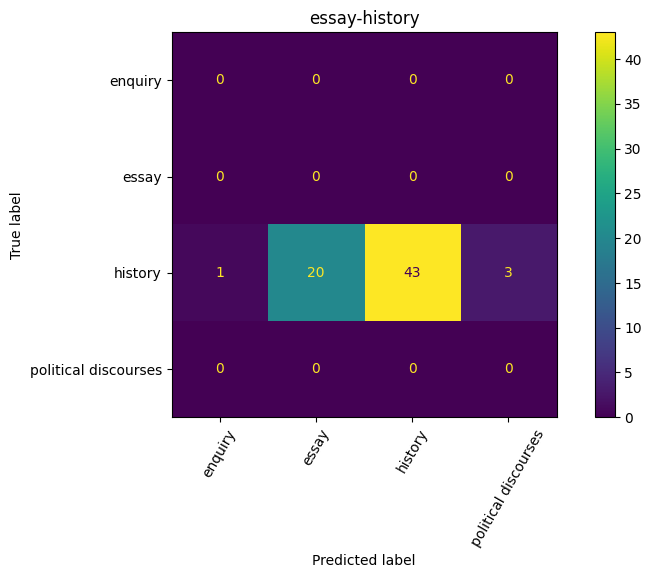

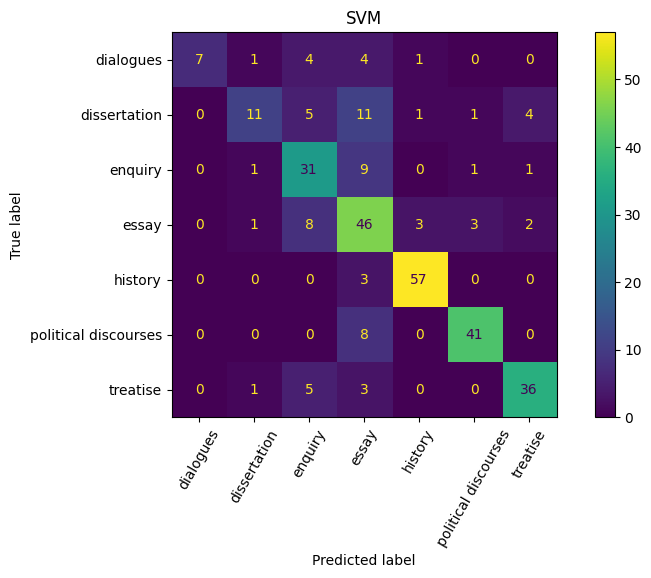

In [6]:
svm_model = SVC()
start = time.time()
d = run_model(svm_model, 'SVM')
print(f'Training time: {time.time()-start} s')

In [ ]:
# it mostly mistakes essay-like things for essay-like things

In [ ]:
run_many(svm_model)

# Logistic Regression

In [7]:
from sklearn.linear_model import LogisticRegression

Accuracy: 0.7164179104477612%
Accuracy: 0.7516129032258064%
Training time: 2.5158913135528564 s


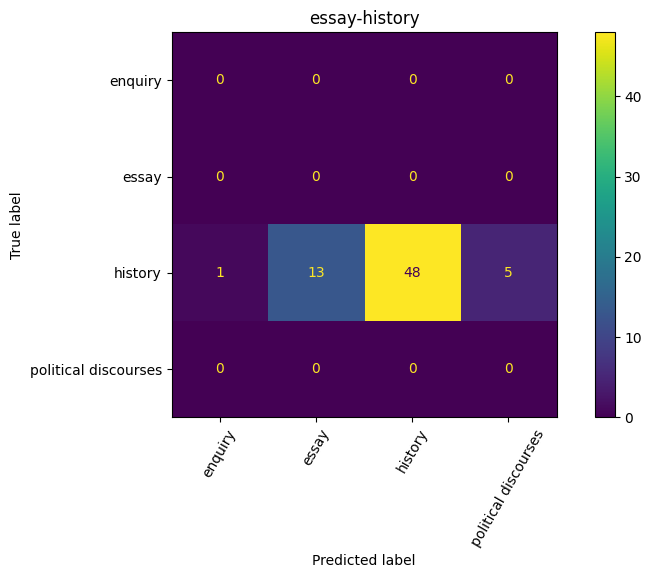

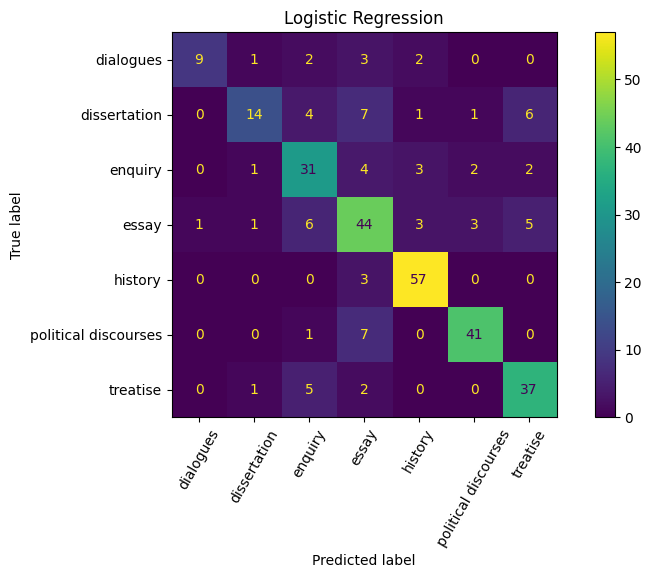

In [8]:
logreg_model = LogisticRegression()
start = time.time()
run_model(logreg_model, 'Logistic Regression')
print(f'Training time: {time.time()-start} s')

In [ ]:
run_many(logreg_model, 15)

## Collecting mistakes

In [ ]:
svm_mistakes = run_model(svm_model, 
                         'SVM', 
                         matrix=False, 
                         collect_mistakes=True, 
                         print_accuracy=False)['mistakes']

In [ ]:
logreg_mistakes = run_model(logreg_model, 
                            'Logreg', 
                            matrix=False, 
                            collect_mistakes=True, 
                            print_accuracy=False)['mistakes']

In [ ]:
mistakes_merged = logreg_mistakes.merge(svm_mistakes, how='outer')

In [ ]:
mistakes_merged.to_csv('mistakes.csv', index=False)

# Other models

## Gradient boosting

In [9]:
from sklearn.ensemble import GradientBoostingClassifier

Accuracy: 0.6119402985074627%
Accuracy: 0.6774193548387096%
Training time: 37.63752627372742 s


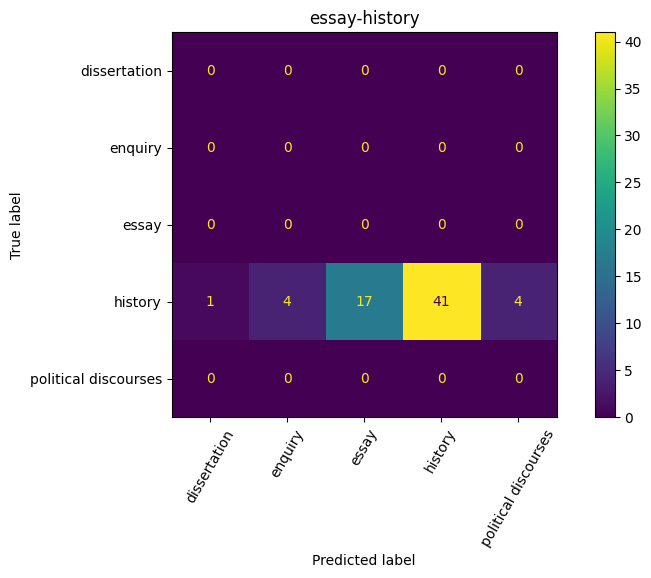

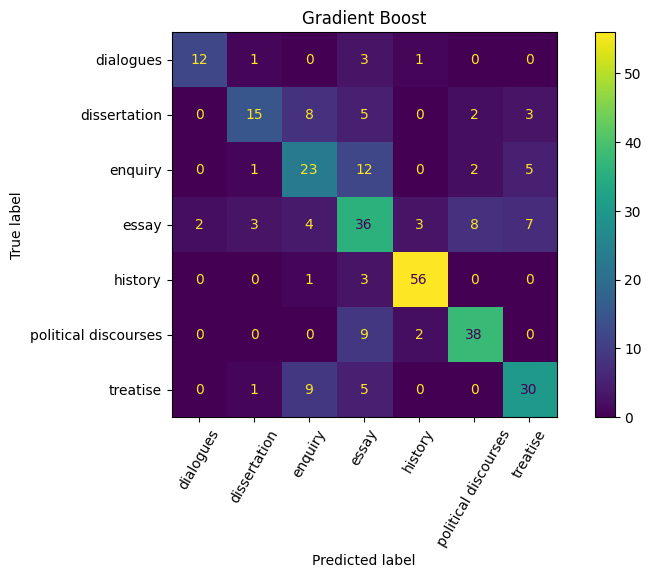

In [10]:
gb_model = GradientBoostingClassifier()
start = time.time()
run_model(gb_model, 'Gradient Boost')
print(f'Training time: {time.time()-start} s')

## Decision tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
dt_model = DecisionTreeClassifier()
start = time.time()
run_model(dt_model, 'Decision Tree')
print(f'Training time: {time.time()-start} s')

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
forest_model = RandomForestClassifier(n_estimators=10)
start = time.time()
run_model(forest_model, 'Random Forest')
print(f'Training time: {time.time()-start} s')